# load packages

In [16]:
import scipy, glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat
from utils import load_behavior_data

In [32]:
## all files
all_files = glob.glob( 'Rats/*.mat')

all_files = glob.glob('/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehVar-main/Rats/*.mat')

print(f"Found {len(all_files)} files.")
all_files.sort()

## load one example dataset
fnum = 1
file = all_files[fnum]

# load .mat file <----------
# make sure it has the dataframe
# and that it has session number as column 

beh_df = load_behavior_data(file)

Found 414 files.


we want to make plots of wait time as a function of trial from the point of block switch for each of the 4 transitions : Low to Mixed, High to Mixed, Mixed to Low, Mixed to High

1) we need to identify the block switches for each of these trials

2) create columns for trial index from each of the transition types (add 4 columns?). e.g. trials before the transition go -1, -2, -3 .... until the start of the previous block (put nan everywhere else). trials from the transition onwards go 0, 1, 2, 3, ... until the end of the post-transition block.

3) we need to standardize wait-times across blocks, in a reward-specific way. for each reward volume, let's say for 5 uL, take all trials [with that offer and that were optouts and that were not violations and had non-nan wait times], and "z-score" them. i.e. for this subselection of trials, take their mean and standard deviation and use that to rescale their wait_times. so let's say you have trials_subselected. then :
    
    m = mean(wait_times[trials_subselected])

    s = std(wait_times[trials_subselected]) 
    
    wait_times[trials_subselected] = (wait_times[trials_subselected] - m )/s

## additional pre-processing 

### Step 1: get trial distance to transition for each transition type

In [24]:
## add column for each transition type 

prev_block = [ 1,        1,         2,        3]
curr_block = [ 2,        3,         1,        1]
tname =    ['M_to_H', 'M_to_L', 'H_to_M', 'L_to_M']

# get block switches
b0 = beh_df['block'].values[:-1]
b1 = beh_df['block'].values[1:]

# find where block transitions occur
switches = np.where(b0 != b1)[0] + 1  # +1 to account for the shift in the array

# what are the previous and current blocks at these switches?
bprev = beh_df['block'].values[switches-1]
bcurr = beh_df['block'].values[switches]

# initialize transition columns as nan 
for name in tname:
    beh_df[name] = np.nan

# fill transition columns
for i, t0 in enumerate(switches):
    # which session is this?
    curr_session = beh_df['session_num'].values[t0]

    # which trials to fill? from last switch to next switch, but restrict to current session

    ## ts: from which trial? 
    ts = t0
    while ts > 0 and beh_df['session_num'].values[ts - 1] == curr_session:
        ts -= 1
        if beh_df['block'].values[ts] != bprev[i]:
            ts += 1
            break

    ## te: to which trial?
    te = t0
    while te < len(beh_df) and beh_df['session_num'].values[te] == curr_session:
        if beh_df['block'].values[te] != bcurr[i]:
            break
        te += 1
    
    # which transition type?
    for j, (b0, b1) in enumerate(zip(prev_block, curr_block)):
        if (bprev[i] == b0) and (bcurr[i] == b1): # if the previous and current blocks match the transition type
            # fill the transition column with the distance to the transition start
            idx = np.arange(ts, te)
            beh_df.loc[idx, tname[j]] = idx - t0 # distance to transition start
       


### visualizing the transitions

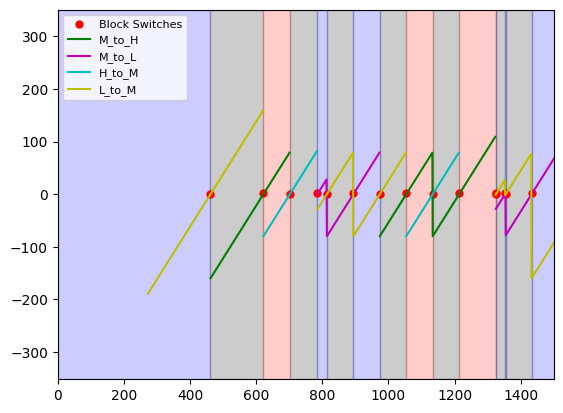

In [25]:
# plotting the transition trials
plt.plot( switches, beh_df['block'].values[switches], 'ro', markersize=5, label='Block Switches')
# fill background colors for each block
unique_blocks = beh_df['block'].unique()
block_colors = {1: 'black', 2: 'red', 3: 'blue'}
for i, t0 in enumerate(switches):
    if i == 0:
        plt.axvspan(0, t0, color=block_colors[beh_df['block'].values[0]], alpha=0.2)
    else:
        plt.axvspan(switches[i-1], t0, color=block_colors[beh_df['block'].values[t0-1]], alpha=0.2)

# plot the distances to transitions
plt.plot( beh_df['M_to_H'], 'g', label='M_to_H')
plt.plot( beh_df['M_to_L'], 'm', label='M_to_L')
plt.plot( beh_df['H_to_M'], 'c', label='H_to_M')
plt.plot( beh_df['L_to_M'], 'y', label='L_to_M')
plt.xlim(0,1500)
plt.legend(fontsize=8)

## z-score offer-specific waittimes

In [26]:
unique_rewards = beh_df['reward'].unique()
num_sessions = beh_df['session_num'].nunique()

beh_df['z_wait_time'] = np.nan  # initialize z-score column for wait times

# for each session
for snum in range(num_sessions):
    # for each reward
    for reward in unique_rewards:
        # get trial indices for this reward and session,  only use optout trials, exclude NaNs and violations
        trial_indices = beh_df[
            (beh_df['session_num'] == snum + 1) &
            (beh_df['reward'] == reward) &
            (beh_df['optout'] == 1) &
            (~beh_df['wait_time'].isna()) &
            (beh_df['vios'] == 0)
        ].index

        # if there are no trials for this reward in this session, skip
        if len(trial_indices) == 0:
            continue

        # calculate z-score of wait times for these trials
        wait_times = beh_df.loc[trial_indices, 'wait_time']
        m = wait_times.mean()
        s = wait_times.std()
        z_scores = (wait_times - m) / s if s != 0 else np.zeros(len(wait_times))

        # add z-scores to the dataframe
        beh_df.loc[trial_indices, 'z_wait_time'] = z_scores

### OR

# z-score all together

for reward in unique_rewards:
    # get trial indices for this reward,  only use optout trials, exclude NaNs and violations [all sessions]
    trial_indices = beh_df[
        (beh_df['reward'] == reward) &
        (beh_df['optout'] == 1) &
        (~beh_df['wait_time'].isna()) &
        (beh_df['vios'] == 0)
    ].index

    # if there are no trials for this reward in this session, skip
    if len(trial_indices) == 0:
        continue

    # calculate z-score of wait times for these trials
    wait_times = beh_df.loc[trial_indices, 'wait_time']
    m = wait_times.mean()
    s = wait_times.std()
    z_scores = (wait_times - m) / s if s != 0 else np.zeros(len(wait_times))

    # add z-scores to the dataframe
    beh_df.loc[trial_indices, 'z_wait_time'] = z_scores


## step 3: get z-score wait-time as function of distance to transition 

restrict to +/- 15 trials

In [27]:
## for each transition , plot the z-scored wait times
max_trials = 15
ntrials = 2*max_trials + 1  # number of trials to plot around the transition
nttypes = len(tname)  # number of transition types

# initialize empty array
z_wait_times = np.empty((ntrials, nttypes))
z_wait_times.fill(np.nan)

# for each transition type, get the z-scored wait times
for i, t in enumerate(tname):
    # use wait times for optout trials only, exclude NaNs and violations, use the corresponding column to find its distance to transition
    trials_to_use = beh_df[
        (beh_df['optout'] == 1) &
        (~beh_df['z_wait_time'].isna()) &
        (beh_df['vios'] == 0) &
        (~beh_df[t].isna()) &
        (beh_df[t] >= -max_trials) &
        (beh_df[t] <= max_trials)
    ].index

    # get the distance to transition for these trials
    distances = beh_df.loc[trials_to_use, t].values
    # get the z-scored wait times for these trials
    z_scores = beh_df.loc[trials_to_use, 'z_wait_time'].values

    # get the mean z-score for each distance
    for d in range(-max_trials, max_trials + 1):
        mask = distances == d
        if np.any(mask):
            z_wait_times[d + max_trials, i] = z_scores[mask].mean()

### plot the z-scored wait times for each transition type

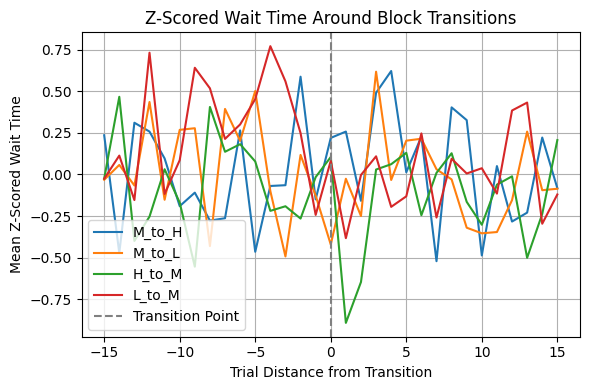

In [28]:
x_vals = np.arange(-max_trials, max_trials + 1)
plt.figure(figsize=(6, 4))

for i, t in enumerate(tname):
    plt.plot(x_vals, z_wait_times[:, i], label=t)

plt.axvline(0, color='gray', linestyle='--', label='Transition Point')
plt.xlabel('Trial Distance from Transition')
plt.ylabel('Mean Z-Scored Wait Time')
plt.title('Z-Scored Wait Time Around Block Transitions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# multi-animal analysis

1. create a function to return the transition dynamics for each file/rat
2. avg transition dynamics across rats


In [12]:
def get_transition_dynamics(file, max_trials=15):
    beh_df = load_behavior_data(file)
    tname = ['M_to_H', 'M_to_L', 'H_to_M', 'L_to_M']
    
    # get block switches
    b0 = beh_df['block'].values[:-1]
    b1 = beh_df['block'].values[1:]
    switches = np.where(b0 != b1)[0] + 1
    bprev = beh_df['block'].values[switches - 1]
    bcurr = beh_df['block'].values[switches]
    prev_block = [1, 1, 2, 3]
    curr_block = [2, 3, 1, 1]

    # initialize columns
    for name in tname:
        beh_df[name] = np.nan

    for i, t0 in enumerate(switches):
        curr_session = beh_df['session_num'].values[t0]

        ts = t0
        while ts > 0 and beh_df['session_num'].values[ts - 1] == curr_session:
            ts -= 1
            if beh_df['block'].values[ts] != bprev[i]:
                ts += 1
                break

        te = t0
        while te < len(beh_df) and beh_df['session_num'].values[te] == curr_session:
            if beh_df['block'].values[te] != bcurr[i]:
                break
            te += 1

        for j, (b0, b1) in enumerate(zip(prev_block, curr_block)):
            if (bprev[i] == b0) and (bcurr[i] == b1):
                idx = np.arange(ts, te)
                beh_df.loc[idx, tname[j]] = idx - t0

    # z-score wait times by reward
    unique_rewards = beh_df['reward'].unique()
    beh_df['z_wait_time'] = np.nan

    for reward in unique_rewards:
        trial_indices = beh_df[
            (beh_df['reward'] == reward) &
            (beh_df['optout'] == 1) &
            (~beh_df['wait_time'].isna()) &
            (beh_df['vios'] == 0)
        ].index
        if len(trial_indices) == 0:
            continue
        wait_times = beh_df.loc[trial_indices, 'wait_time']
        m = wait_times.mean()
        s = wait_times.std()
        z_scores = (wait_times - m) / s if s != 0 else np.zeros(len(wait_times))
        beh_df.loc[trial_indices, 'z_wait_time'] = z_scores

    # compute z_wait_times matrix
    ntrials = 2 * max_trials + 1
    nttypes = len(tname)
    z_wait_times = np.empty((ntrials, nttypes))
    z_wait_times.fill(np.nan)

    for i, t in enumerate(tname):
        trials_to_use = beh_df[
            (beh_df['optout'] == 1) &
            (~beh_df['z_wait_time'].isna()) &
            (beh_df['vios'] == 0) &
            (~beh_df[t].isna()) &
            (beh_df[t] >= -max_trials) &
            (beh_df[t] <= max_trials)
        ].index

        distances = beh_df.loc[trials_to_use, t].values.astype(int)
        z_scores = beh_df.loc[trials_to_use, 'z_wait_time'].values

        for d in range(-max_trials, max_trials + 1):
            mask = distances == d
            if np.any(mask):
                z_wait_times[d + max_trials, i] = z_scores[mask].mean()

    return z_wait_times

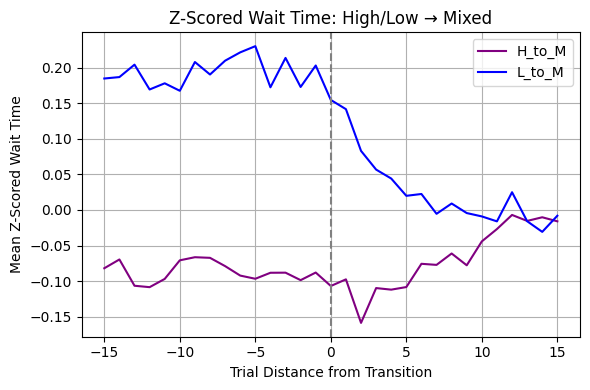

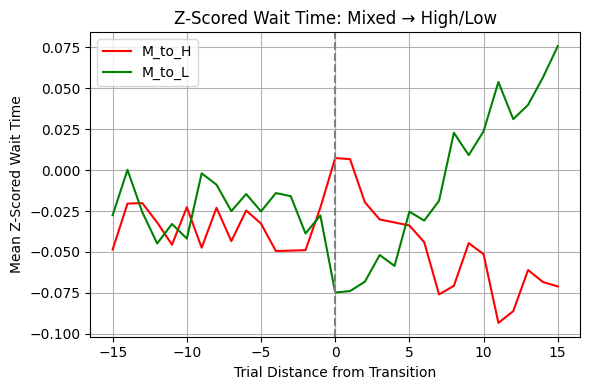

In [33]:
all_dynamics = []

for file in all_files:
    try:
        zmat = get_transition_dynamics(file)
        all_dynamics.append(zmat)
    except Exception as e:
        print(f"Skipping file {file} due to error: {e}")

# average across rats
avg_z_dynamics = np.nanmean(np.stack(all_dynamics), axis=0)

# plot: High and Low to Mixed (H_to_M and L_to_M)
plt.figure(figsize=(6, 4))
x_vals = np.arange(-15, 16)
plt.plot(x_vals, avg_z_dynamics[:, 2], label='H_to_M', color='purple')
plt.plot(x_vals, avg_z_dynamics[:, 3], label='L_to_M', color='blue')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Trial Distance from Transition')
plt.ylabel('Mean Z-Scored Wait Time')
plt.title('Z-Scored Wait Time: High/Low → Mixed')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# plot: Mixed to High and Low (M_to_H and M_to_L)
plt.figure(figsize=(6, 4))
plt.plot(x_vals, avg_z_dynamics[:, 0], label='M_to_H', color='red')
plt.plot(x_vals, avg_z_dynamics[:, 1], label='M_to_L', color='green')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Trial Distance from Transition')
plt.ylabel('Mean Z-Scored Wait Time')
plt.title('Z-Scored Wait Time: Mixed → High/Low')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()